# Cume Dist and Percent Rank

Currently Percent rank implemented by SQL Databases and Pandas Percent rank use different algorithms.

Pandas Percent Rank uses the same algoritm used by SQL Databases CumeDist function.

The calculation used by SQL Databases for CumeDist and Percent rank are:


$$
PERCENT\_RANK = (RANK – 1)/(COUNT -1)
$$

$$
CUME\_DIST = RANK/COUNT
$$


Current, [Ibis](http://ibis-project.org) uses the approach of Pandas, but probably should use the same 
behavior used by the SQL Databases.

More information about the difference between Percent Rank and CumeDist [here](https://www.sqlservercentral.com/articles/whats-the-difference-between-percent_rank-and-cume_dist)


Some Ibis reference about the current implementation:

- https://github.com/ibis-project/ibis/blob/1.3.0/ibis/pandas/execution/window.py#L360
- https://github.com/ibis-project/ibis/blob/1.3.0/ibis/tests/all/test_window.py#L41


This notebook aims to implement a function for sql percent_rank using pandas and test it against 
[OmniSciDB](https://docs.omnisci.com/).

In [1]:
from copy import copy

import ibis
import pandas as pd
# local
from settings import conf
from utils import cursor2df

### Setup

In [2]:
BACKENDS = ['omniscidb']
con = {
    backend: getattr(ibis, backend).connect(**conf[backend]) 
    for backend in BACKENDS
}

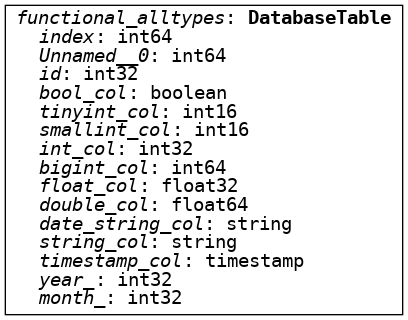

In [3]:
t = con['omniscidb'].table('functional_alltypes')
t

### Percent Rank and CumeDist definition

In [4]:
def win_count(se):
    count = copy(se)
    count[:] = se.count()
    return count


def sql_percent_rank(se):
    """
    PERCENT_RANK = (RANK – 1)/(COUNT -1)
    """
    return (se.rank(method='min') - 1) / (se.apply(win_count) - 1)


def sql_cume_dist(se):
    """
    CUME_DIST = RANK/COUNT
    """
    return se.rank(method='min') / se.apply(win_count)


def pd_percent_rank(se): 
    return se.rank(method='min', pct=True)

### Test CUME DIST using Ibis/OmniSciDB

In [6]:
alltypes = t.execute()

analytic_alltypes = alltypes.sort_values('id').groupby('string_col')

result = alltypes.assign(
    pandas_pct_rank=pd_percent_rank(analytic_alltypes.id),
    cume_dist=sql_cume_dist(analytic_alltypes.id),
    pct_rank=sql_percent_rank(analytic_alltypes.id),
).set_index('id').sort_index()

# display(result[['pandas_pct_rank', 'cume_dist']].describe())
pd.testing.assert_series_equal(
    result['pandas_pct_rank'], result['cume_dist'],
    check_dtype=False,
    check_names=False,
)

### Test OmniSciDB Percent Rank

In [7]:
sql = '''
SELECT 
    id, cume_dist() OVER (PARTITION BY "string_col" ORDER BY "id") AS cume_dist_val,
    percent_rank() OVER (PARTITION BY "string_col" ORDER BY "id") AS percent_rank_val
FROM functional_alltypes
'''

cur = con['omniscidb'].con.execute(sql)
df = cursor2df(cur).set_index('id').sort_index()
df.head()

,cume_dist_val,percent_rank_val
id,,
0,0.00137,0.0
1,0.00137,0.0
2,0.00137,0.0
3,0.00137,0.0
4,0.00137,0.0


In [8]:
pd.testing.assert_series_equal(
    result['cume_dist'], 
    df['cume_dist_val'],
    check_dtype=False,
    check_names=False,
)

pd.testing.assert_series_equal(
    result['cume_dist'], 
    df['cume_dist_val'],
    check_dtype=False,
    check_names=False,
)

## Conclusions

This notebook implemented Percent Rank and CumeDist for pandas and test them against OmniSciDB results with a positive result.  